## Отчет №6 Создание интерфейса


Цели этапа:

1) Разработать пользовательский интерфейс в Telegram для загрузки фотографий и запросов к искусственному интеллекту.

2) Интегрировать модель искусственного интеллекта в интерфейс Telegram.

https://t.me/BotEmote_bot

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from telegram import Update
from telegram.ext import Application, CommandHandler, MessageHandler, filters, CallbackContext
from PIL import Image
import io
import nest_asyncio
from telegram import Bot

In [ ]:
nest_asyncio.apply()

model = torch.load('/content/drive/MyDrive/ИИ/V3/efficientnet_b0_full.pth')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model.eval()

unique_labels = ["Злость", "Грусть", "Счастье"]

def process_image(image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image).unsqueeze(0)
    return image_tensor

API_TOKEN = "8100399006:AAH5NnFdFmyjdlDhUnG8gqICewcUOpLaclQ"
bot = Bot(token=API_TOKEN)

async def start(update: Update, context: CallbackContext) -> None:
    await update.message.reply_text("Привет! Я бот для классификации эмоций на изображениях. Отправь мне изображение, и я попробую его классифицировать!")

async def handle_image(update: Update, context: CallbackContext) -> None:
    photo = update.message.photo[-1]
    file_info = await bot.get_file(photo.file_id)
    downloaded_file = await file_info.download_as_bytearray()
    image = Image.open(io.BytesIO(downloaded_file))
    processed_image = process_image(image)
    processed_image = processed_image.to(device)

    with torch.no_grad():
        predictions = model(processed_image)
        probabilities = F.softmax(predictions, dim=1)
        predicted_index = torch.argmax(probabilities, dim=1).item()
        predicted_label = unique_labels[predicted_index]
        confidence = probabilities[0][predicted_index].item()

    await update.message.reply_text(f"Класс: {predicted_label}")

def main():
    application = Application.builder().token(API_TOKEN).build()
    application.add_handler(CommandHandler("start", start))
    application.add_handler(MessageHandler(filters.PHOTO, handle_image))
    application.run_polling()

if __name__ == "__main__":
    main()

Результат работы:


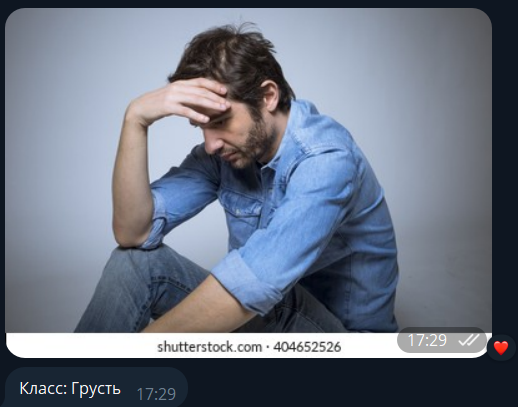

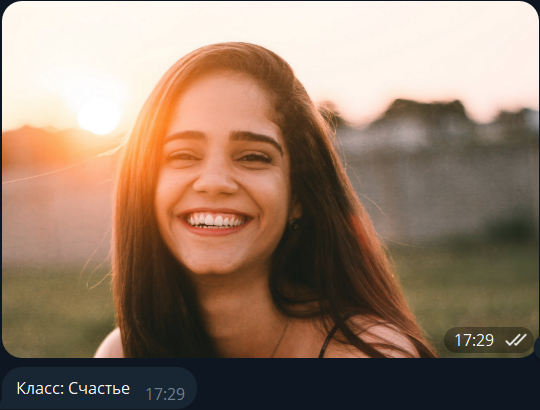

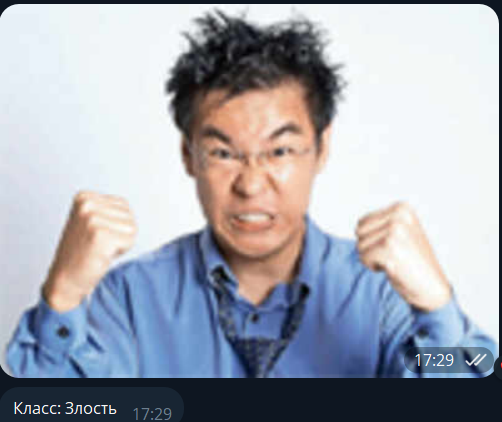

Модель была успешно интегрированна в бота.
